# Final Project: Interior Design Classification
## Load data

In [519]:
import os
import time
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Define variable

In [520]:
TRAIN_DIR = '../input/interior-data-new/1_datasets/try_padding_dataset/original/train'
VAL_DIR = '../input/interior-data-new/1_datasets/try_padding_dataset/original/val'
TEST_DIR = '../input/interior-data-new/1_datasets/try_padding_dataset/original/val'
BATCH_SIZE = 32
EPOCHS = 25
TARGET_SIZE = (224, 224)
IMAGE_CHANNELS=3
BASEMODEL_PATH = 'models/base_model.h5'
BESTMODEL_PATH = 'models/best_model.h5'
BESTWEIGHTS_PATH = 'models/best_weights.h5'
HISTORY_PATH = 'models/history.npy'

PROJECT_ROOT_DIR = "."
MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
os.makedirs(MODELS_PATH, exist_ok=True)

## Get all labels

In [521]:
# Get list subfolder
list_subfolder = os.listdir(TRAIN_DIR)
list_subfolder = sorted(list_subfolder)
print('All labels : ', list_subfolder)

All labels :  ['ArtDecor', 'Hitech', 'Indochina', 'Industrial', 'Scandinavian']


## Define function get info data

In [522]:
import pandas as pd

def get_data(DIR):
    LABELS = []
    IMAGES = []
    for subfolder in list_subfolder:
        sunfolder_path = os.path.join(DIR, subfolder)
        print(sunfolder_path)
        for file_name in os.listdir(sunfolder_path):
            file_path = os.path.join(subfolder, file_name)
            IMAGES.append(file_path)
            LABELS.append(subfolder)
    df = pd.DataFrame({
        'image': IMAGES,
        'label': LABELS
    })
    df.head()
    return df

## Define function show info data

In [523]:
def plot_count(df, title=''):
    print(df.label.value_counts())
    df.label.value_counts().plot(kind='barh', 
                                 figsize=(10,5),
                                 title=title,
                                 color=plt.cm.Set2(np.arange(len(df))),
                                 rot=0)
    for i, v in df.label.value_counts().reset_index().iterrows():
        plt.text(v.label + 5, i - 0.1 , v.label, color='black')
    plt.show()

## Get label and file path data Train Data

In [524]:
### Get data to dataframe
df_train = get_data(TRAIN_DIR)

../input/interior-data-new/1_datasets/try_padding_dataset/original/train/ArtDecor
../input/interior-data-new/1_datasets/try_padding_dataset/original/train/Hitech
../input/interior-data-new/1_datasets/try_padding_dataset/original/train/Indochina
../input/interior-data-new/1_datasets/try_padding_dataset/original/train/Industrial
../input/interior-data-new/1_datasets/try_padding_dataset/original/train/Scandinavian


In [525]:
### Save data to csv
df_train.to_csv('df_train.csv')

ArtDecor        80
Indochina       80
Industrial      80
Hitech          80
Scandinavian    80
Name: label, dtype: int64


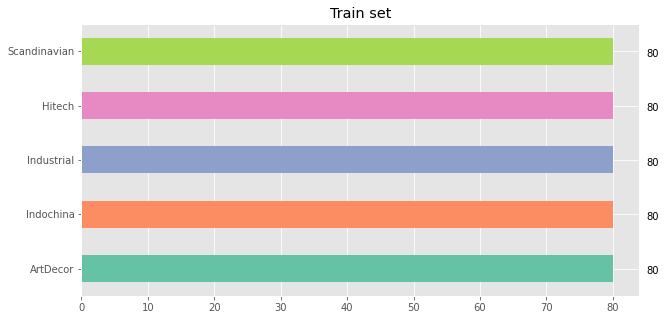

In [526]:
### Plot count sample
plot_count(df_train, title="Train set")

## Get label and file path data Val Data

In [527]:
### Get data to dataframe
df_val = get_data(VAL_DIR)

../input/interior-data-new/1_datasets/try_padding_dataset/original/val/ArtDecor
../input/interior-data-new/1_datasets/try_padding_dataset/original/val/Hitech
../input/interior-data-new/1_datasets/try_padding_dataset/original/val/Indochina
../input/interior-data-new/1_datasets/try_padding_dataset/original/val/Industrial
../input/interior-data-new/1_datasets/try_padding_dataset/original/val/Scandinavian


In [528]:
### Save data to csv
df_val.to_csv('df_val.csv')

Scandinavian    20
ArtDecor        20
Hitech          20
Indochina       20
Industrial      20
Name: label, dtype: int64


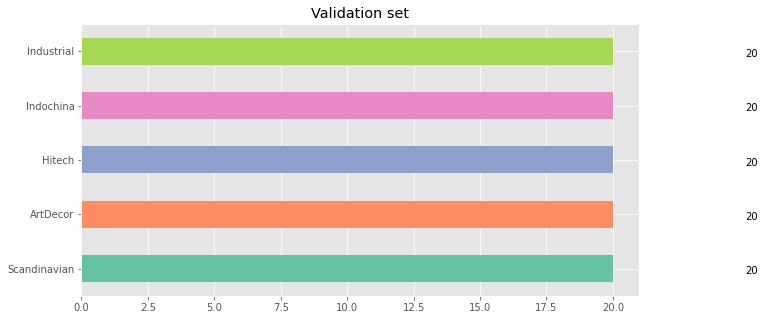

In [529]:
### Plot count sample
plot_count(df_val, title="Validation set")

## Get label and file path data Test Data

In [530]:
### Get data to dataframe
df_test = get_data(TEST_DIR)

../input/interior-data-new/1_datasets/try_padding_dataset/original/val/ArtDecor
../input/interior-data-new/1_datasets/try_padding_dataset/original/val/Hitech
../input/interior-data-new/1_datasets/try_padding_dataset/original/val/Indochina
../input/interior-data-new/1_datasets/try_padding_dataset/original/val/Industrial
../input/interior-data-new/1_datasets/try_padding_dataset/original/val/Scandinavian


In [531]:
### Save data to csv
df_test.to_csv('df_test.csv')

Scandinavian    20
ArtDecor        20
Hitech          20
Indochina       20
Industrial      20
Name: label, dtype: int64


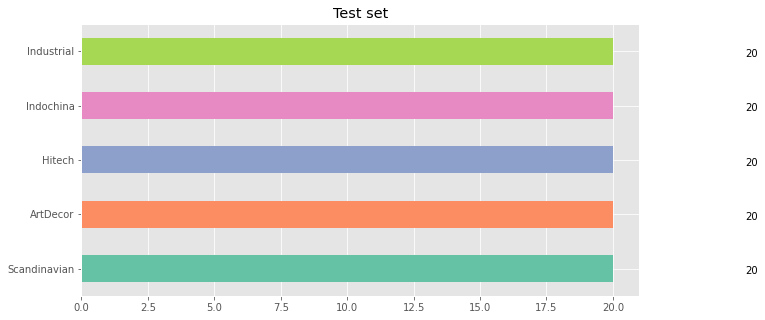

In [532]:
### Plot count sample
plot_count(df_test, title="Test set")

## Data Augmentation

In [533]:
### train_set with ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator,load_img ,img_to_array
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=7,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1,
                                   horizontal_flip=True)
train_set = train_datagen.flow_from_dataframe(dataframe=df_train,
                                              directory=TRAIN_DIR,
                                              x_col="image",
                                              y_col="label",
                                              shuffle=True,
                                              class_mode="sparse",
                                              batch_size=BATCH_SIZE,
                                              target_size=TARGET_SIZE)

Found 400 validated image filenames belonging to 5 classes.


In [534]:
### Show demo Data Augmentation
example_df = df_train.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    TRAIN_DIR,
    x_col="image",
    y_col="label",
    target_size=TARGET_SIZE,
    class_mode='sparse'
)

Found 1 validated image filenames belonging to 1 classes.


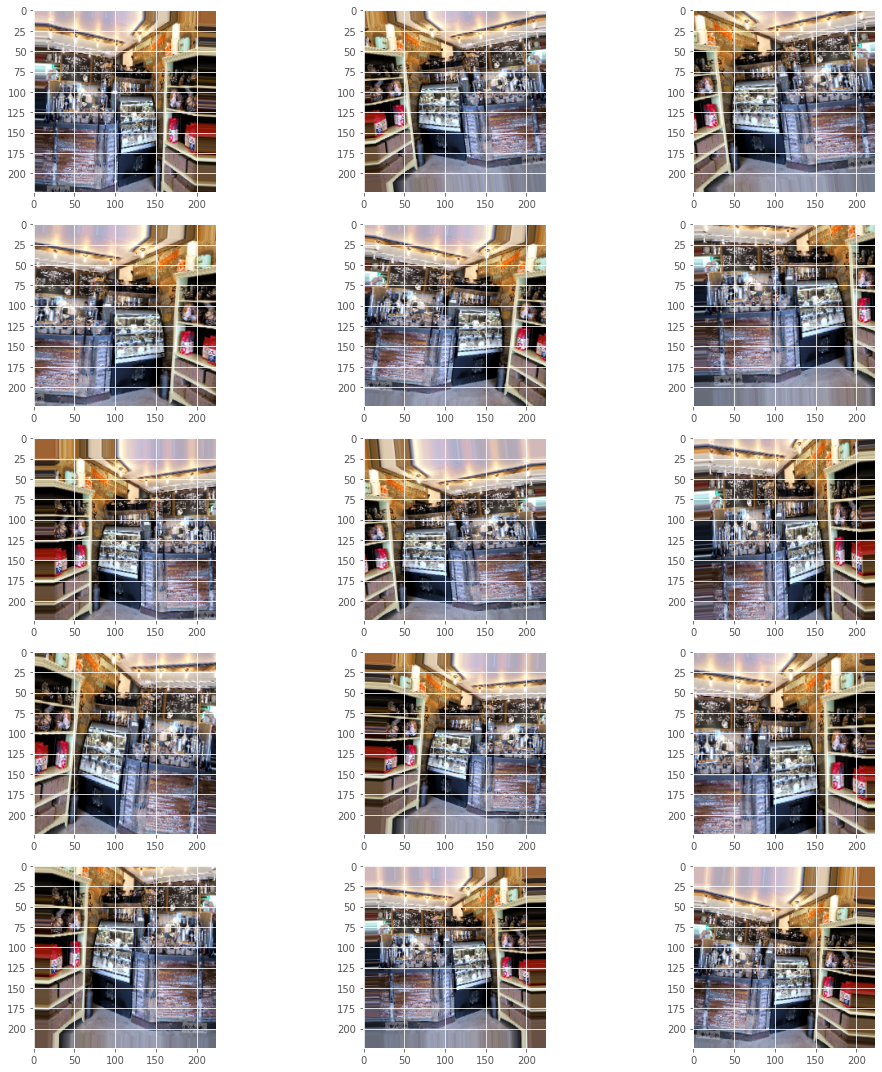

In [535]:
### Show image demo
plt.figure(figsize=(15, 15))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [536]:
### val_set with ImageDataGenerator
val_datagen = ImageDataGenerator(rescale=1./255)
val_set = val_datagen.flow_from_dataframe(dataframe=df_val,
                                          directory=VAL_DIR,
                                          x_col="image",
                                          y_col="label",
                                          class_mode="sparse", 
                                          batch_size=BATCH_SIZE,
                                          target_size=TARGET_SIZE)

Found 100 validated image filenames belonging to 5 classes.


## Build model

In [537]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.xception import Xception
from keras.applications import VGG19, ResNet50, NASNetLarge, DenseNet201, VGG16, \
InceptionResNetV2, Xception, ResNet152, InceptionV3, DenseNet121, ResNet50V2
from keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout,\
MaxPooling2D, Conv2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Sequential
import tensorflow as tf
import numpy as np

if os.path.exists(BASEMODEL_PATH):
    os.remove(BASEMODEL_PATH)
    print("The file removed successfully!")
else:
    print("The file does not exist")

tf.random.set_seed(42)
np.random.seed(42)

# build model
def define_model():
    base_model = DenseNet201(weights="imagenet", 
                          include_top=False, 
                          input_shape=(224, 224, 3))
    
#     for layer in base_model.layers:
#         layer.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Flatten(),
        Dense(128, activation='relu', kernel_initializer='he_uniform'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])

    return model

model = define_model()


# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# # model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# # model.add(Dropout(0.25))

# # model.add(Conv2D(128, (3, 3), activation='relu'))
# # model.add(BatchNormalization())
# # model.add(MaxPooling2D(pool_size=(2, 2)))
# # model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Dense(5, activation='softmax'))

model.summary()
if os.path.exists(BASEMODEL_PATH):
    os.remove(BASEMODEL_PATH)
model.save(BASEMODEL_PATH)





# model = Sequential()
# model.add(Conv2D(32, (2, 2), activation='relu', input_shape=(224, 224, 3)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# # model.add(Dropout(0.25))

# model.add(Conv2D(64, (2, 2), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # model.add(Dropout(0.25))

# # model.add(Conv2D(128, (3, 3), activation='relu'))
# # model.add(BatchNormalization())
# # model.add(MaxPooling2D(pool_size=(2, 2)))
# # model.add(Dropout(0.25))

# model.add(GlobalAveragePooling2D())
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(5, activation='softmax'))

# model.summary()
# if os.path.exists(BASEMODEL_PATH):
#     os.remove(BASEMODEL_PATH)
# model.save(BASEMODEL_PATH)

The file removed successfully!
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_12  (None, 1920)              0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 1920)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 128)               245888    
_________________________________________________________________
batch_normalization_73 (Batc (None, 128)               512       
_________________________________________________________________
dropout_31 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_41 (Dense)      

In [538]:
import math
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0
    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=0.1):
    model.compile(loss="sparse_categorical_crossentropy", optimizer='Nadam', metrics=["accuracy"])
    init_weights = model.get_weights()
    iterations = math.ceil(len(X)) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, 
                        validation_data=y, 
                        epochs=epochs, batch_size=batch_size, callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    print("{} => {}".format("GL", "Good Loss"))
    print("{} => {}".format("BLL", "Bad Loss Lastest"))
    plt.figure(figsize=(10,5))
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses))])
    
    good_loss = [rates[losses.index(min(losses))], min(losses)]
    plt.plot(good_loss[0], good_loss[1], 'go')
    plt.text(good_loss[0], good_loss[1]+10**-2, 
             "GL: (lr = {:f})".format(good_loss[0]), fontsize=12)
    
    bad_index_lastest = losses.index(min(losses))
    for index in range(losses.index(min(losses))+1, losses.index(min(losses))+20):
        if (losses[index] > losses[bad_index_lastest]) and (losses[index] < 1.6):
            bad_index_lastest = index
        else: break
    bad_loss_lastest = [rates[bad_index_lastest], losses[bad_index_lastest]]
    plt.plot(bad_loss_lastest[0], bad_loss_lastest[1], 'ro')
    plt.text(bad_loss_lastest[0], bad_loss_lastest[1]+10**-2, 
             "BLL: (lr = {:f})".format(bad_loss_lastest[0]), fontsize=12)
    
    good_lr = good_loss[0]
    
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.ylim(0, 3)
    return good_lr

13/13 [==============================] - 86s 2s/step - loss: 2.6362 - accuracy: 0.2269 - val_loss: 2636390068696542817730691072.0000 - val_accuracy: 0.2000
GL => Good Loss
BLL => Bad Loss Lastest
Good learning rate: 0.0028942665085196495


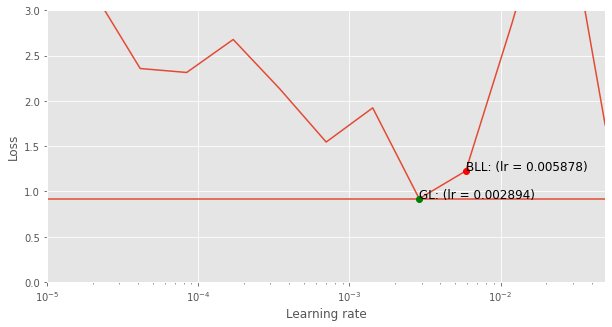

In [539]:
from keras.models import load_model

tf.random.set_seed(42)
np.random.seed(42)

model = load_model(BASEMODEL_PATH)
batch_size = BATCH_SIZE
rates, losses = find_learning_rate(model, train_set, val_set, epochs=1, batch_size=batch_size)
good_lr = plot_lr_vs_loss(rates, losses)
print('Good learning rate: {}'.format(good_lr))

In [540]:
### save history
import pickle

# In case you want to create a checkpoint
with open('rates_losses_find_learning_rate.pickle', 'wb') as f:
    pickle.dump((rates, losses), f)

In [541]:
# In case you want to create a checkpoint
with open('rates_losses_find_learning_rate.pickle', 'rb') as f:
    rates_, losses_ = pickle.load(f)

len(rates_), len(losses_)

(13, 13)

## Training model

In [542]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Nadam, Adam

tf.random.set_seed(42)
np.random.seed(42)

model = load_model(BASEMODEL_PATH)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Nadam(learning_rate=0.0005), 
              metrics=["accuracy"])

print(model.optimizer.lr)

modelCheckpoint = ModelCheckpoint(
    BESTMODEL_PATH,
    monitor="val_loss",
    save_best_only=True,
)
earlyStopping = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=1, 
                                            verbose=1, 
                                            factor=1/3, 
                                            min_lr=1e-6)

### calculator execution time
start_time = time.time()
history = model.fit(train_set, 
                    validation_data=val_set,
                    epochs=EPOCHS,
                    callbacks=[modelCheckpoint, earlyStopping, learning_rate_reduction])
end_time = time.time()


<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
Epoch 1/25
13/13 [==============================] - 78s 2s/step - loss: 1.7453 - accuracy: 0.4184 - val_loss: 1.4333 - val_accuracy: 0.4200
Epoch 2/25
13/13 [==============================] - 18s 1s/step - loss: 0.5809 - accuracy: 0.8172 - val_loss: 1.6132 - val_accuracy: 0.4200

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00016666667458290854.
Epoch 3/25
13/13 [==============================] - 18s 1s/step - loss: 0.2857 - accuracy: 0.9045 - val_loss: 1.6602 - val_accuracy: 0.4200

Epoch 00003: ReduceLROnPlateau reducing learning rate to 5.555555981118232e-05.
Epoch 4/25
13/13 [==============================] - 17s 1s/step - loss: 0.2074 - accuracy: 0.9373 - val_loss: 1.6194 - val_accuracy: 0.4400
Epoch 5/25
13/13 [==============================] - 17s 1s/step - loss: 0.1998 - accuracy: 0.9279 - val_loss: 1.6171 - val_accuracy: 0.4500
Epoch 6/25
13/13 [==============================] - 17s 1s/step - lo

In [543]:
### Infor train time information and average time for a epochs
execution_time = end_time - start_time
print('Training time: ', execution_time)
print('Number of epochs: ', len(history.history["loss"]))
print('Average time for a epochs: ', execution_time / len(history.history["loss"]))

Training time:  552.4645192623138
Number of epochs:  25
Average time for a epochs:  22.098580770492553


In [544]:
### save history
import pickle

# In case you want to create a checkpoint
with open('history.pickle', 'wb') as f:
    pickle.dump(history.history, f)

In [545]:
# In case you want to create a checkpoint
with open('history.pickle', 'rb') as f:
    history_ = pickle.load(f)
len(history_)

5

## Evaluate model

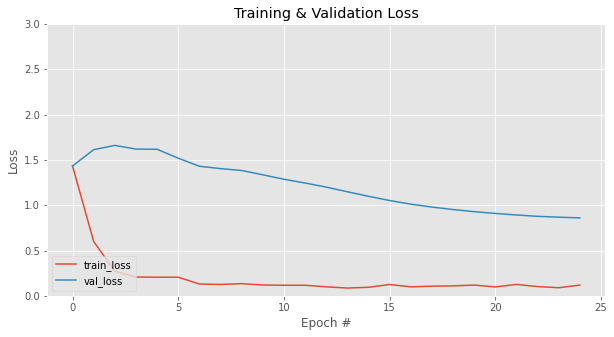

In [546]:
### Plot loss and accuracy train, val
history = history_
epochs_ = len(history["loss"])
plt.style.use("ggplot")
plt.figure(figsize = (10, 5))
plt.plot(np.arange(0, epochs_), history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs_), history["val_loss"], label="val_loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.ylim(0, 3)
plt.show()

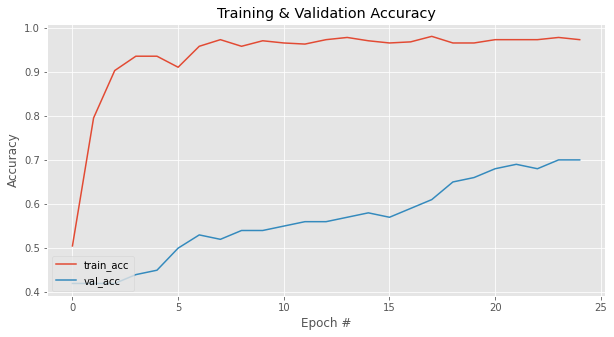

In [547]:
epochs_ = len(history["loss"])
plt.style.use("ggplot")
plt.figure(figsize = (10, 5))
plt.plot(np.arange(0, epochs_), history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs_), history["val_accuracy"], label="val_acc")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

In [548]:
df_test = df_test.sort_values(by=['label'])
df_test

,image,label
0,ArtDecor/[S1][1000_][1000_]Art-Deco-For-the-Ro...,ArtDecor
19,ArtDecor/ArtDecor_552_gq.jpg,ArtDecor
18,ArtDecor/ArtDecor_521_ev.jpg,ArtDecor
17,ArtDecor/art-deco-bedrooms-lead-1552422912_y1.jpg,ArtDecor
16,ArtDecor/ArtDecor_498_t7.jpg,ArtDecor
...,...,...
81,Scandinavian/grey-and-light-wood-Scandinavian-...,Scandinavian
80,Scandinavian/cbae12b36135f1fe5a81a62e2baf1ba1b...,Scandinavian
98,Scandinavian/relaxation-area-on-wooden-windows...,Scandinavian
88,Scandinavian/e5f948cfa00ac40c60c12df4d17957ac3...,Scandinavian


In [549]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_dataframe(dataframe=df_test,
                                            directory=TEST_DIR,
                                            x_col="image",
                                            y_col="label",
                                            class_mode="categorical", 
                                            batch_size=BATCH_SIZE,
                                            target_size=TARGET_SIZE,
                                            shuffle=False)

Found 100 validated image filenames belonging to 5 classes.


In [550]:
### Predict with test dataset
nb_samples = df_test.shape[0]
predict = model.predict(test_set, steps=np.ceil(nb_samples/BATCH_SIZE))

In [551]:
### get 
np.unique(test_set.classes)
y_pred = np.argmax(predict, axis=1)

In [552]:
### Show Classification Report
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
print(classification_report(test_set.classes, y_pred, target_names=list_subfolder))

Classification Report
              precision    recall  f1-score   support

    ArtDecor       0.75      0.45      0.56        20
      Hitech       0.81      0.85      0.83        20
   Indochina       0.69      1.00      0.82        20
  Industrial       0.62      0.65      0.63        20
Scandinavian       0.65      0.55      0.59        20

    accuracy                           0.70       100
   macro avg       0.70      0.70      0.69       100
weighted avg       0.70      0.70      0.69       100



#### Show Confusion Matrix

In [553]:
print('Confusion Matrix')
cm = confusion_matrix(test_set.classes, y_pred)
print(cm)

Confusion Matrix
[[ 9  0  3  4  4]
 [ 0 17  1  1  1]
 [ 0  0 20  0  0]
 [ 1  2  3 13  1]
 [ 2  2  2  3 11]]


<AxesSubplot:>

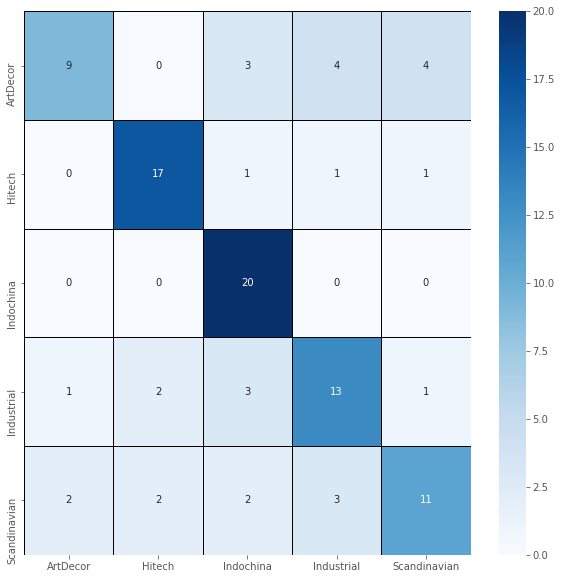

In [554]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(cm , index = list_subfolder , columns = list_subfolder)
plt.figure(figsize = (10,10))
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , 
            linewidth = 1 , annot = True, fmt='' , 
            xticklabels = list_subfolder , yticklabels = list_subfolder)